In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy import stats
from scipy import special


In [2]:
def chiSquaredTest(data, modelfit, plot=True):
    
    normdata = np.sum(data)*modelfit/np.sum(modelfit)
    
    chiresults = stats.chisquare(data, normdata)
    
    print(chiresults)
    if plot:
        try:
            chibins = np.arange(0,int(chiresults.statistic*2),0.1)
        except:
            chibins = np.arange(0,100,0.1)
            
        fig, axs = plt.subplots(1,2)
        axs[0].title.set_text('Chi2 test')
        axs[0].set_ylabel('probability')
        axs[0].set_xlabel('Chi2 statistic')

        axs[0].plot(chibins, stats.chi2.pdf(chibins, df=len(data)-1))
        axs[0].vlines(chiresults.statistic,0,0.05, 'r')
        axs[0].text(chiresults.statistic,0.05, 'p-value: {}'.format(np.round(chiresults.pvalue,2)))
        axs[1].scatter(data,  modelfit, c='k')
        maxval = np.max(data)
        if any(maxval < modelfit):
            maxval = np.max(modelfit)
        axs[1].set_xlim(0,maxval)
        axs[1].set_ylim(0,maxval)
        axs[1].plot([0, maxval],[0, maxval], linestyle=':', color='k')
        axs[0].title.set_text('Chi2 test')
        axs[1].set_ylabel('fit values')
        axs[1].set_xlabel('actual values')
        plt.tight_layout()
        plt.show()
    return chiresults

In [3]:
def uniform(height, X):
    return height*np.ones_like(X)

def uniformParams(data, X):
    height = np.mean(data)
    return height

def fitUniform(data, X):
    '''
    Returns (height, xmean, xsd)
    '''
    params =  uniformParams(data, X)
    error_function = lambda p: np.ravel(uniform(*p, X) - data)
    p, success = optimize.leastsq(error_function, params)
    
    return p             

height : 4.55


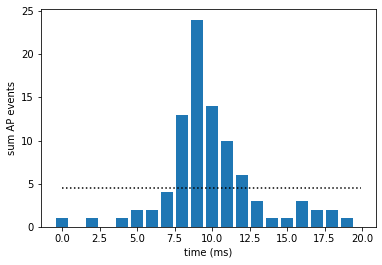

Power_divergenceResult(statistic=158.010989010989, pvalue=6.1736003249757916e-24)


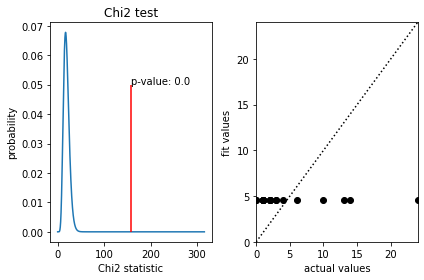

Power_divergenceResult(statistic=158.010989010989, pvalue=6.1736003249757916e-24)

In [4]:
data = np.array([1,0,1,0,1,2,2,4,13,24,14,10,6,3,1,1,3,2,2,1])
bins = np.arange(0,data.shape[0],1)
interp = np.arange(0,data.shape[0],.1)

#data
p = fitUniform(data, bins)
fit = uniform(*p, bins)

#print the fit parameters
param_labels = ['height']
for i, label in enumerate(param_labels):
    print(label, ':', np.round(p[i], 4))

#graph the data
plt.bar(bins, data)
plt.xlabel('time (ms)')
plt.ylabel('sum AP events')

plt.plot(interp, uniform(*p, interp), linestyle=':', c='black')
plt.show()

chiSquaredTest(data, uniform(*p, bins))


## Gaussian distribution

In [5]:
def gaussian(height, xmean, xsd, base):
    return lambda x: height*np.exp(-(((xmean-x)/xsd)**2))+base

def gaussianmoments(data):
    '''
    Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 1D distribution
    '''
    base = np.mean(data[:5])
    datam = data
    datam[datam<0]=0
    total = datam.sum()
    X = np.indices(data.shape)

    xmean = (X*datam).sum()/total
    xsd = np.sqrt(np.abs(np.sum((X-xmean)**2*data)/np.sum(data)))
    height = datam.max()
    
    return height, xmean, xsd, base

def fitGaussian(data):
    '''
    Returns (height, xmean, xsd, base)
    '''
    params = gaussianmoments(data)
    error_function = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(error_function, params)
    
    return p                               

height : 19.8937
mean : 9.2047
std : 1.7302
base : 1.4996


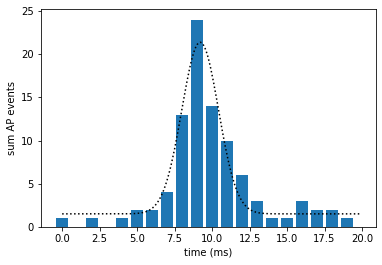

Power_divergenceResult(statistic=12.074500300222534, pvalue=0.8824162213750708)


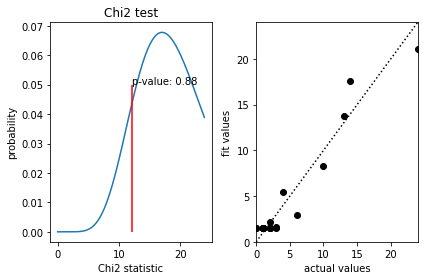

In [6]:
data = np.array([1,0,1,0,1,2,2,4,13,24,14,10,6,3,1,1,3,2,2,1])

bins = np.arange(0,data.shape[0],1)
interp = np.arange(0,data.shape[0],.1)

#data
p = fitGaussian(data)
fit = gaussian(*p)

#print the fit parameters
param_labels = ['height', 'mean', 'std', 'base']
for i, label in enumerate(param_labels):
    print(label, ':', np.round(p[i], 4))

#graph the data
plt.bar(bins, data)
plt.xlabel('time (ms)')
plt.ylabel('sum AP events')

plt.plot(interp, fit(interp), linestyle=':', c='black')
plt.show()


res = chiSquaredTest(data, fit(bins))


## von Mises 

In [7]:
def vonMises(height, xmean, conc):
    '''
    x in radians
    '''
    return lambda x: height*np.exp(conc*np.cos(x-xmean))/(2*np.pi*special.jv(0, conc))

def vonmisesmoments(data, X):
    '''
    X in radians
    Returns (height, xmean, conc)
    the vonMises parameters of a 1D distribution
    '''
    
    datam = data
    datam[datam<0]=0
    total = datam.sum()

    xmean = (X*datam).sum()/total
    conc = np.sqrt(np.abs(np.sum((X-xmean)**2*data)/np.sum(data)))
    height = datam.max()
    
    return height, xmean, conc

def fitVonMises(data, X):
    '''
    X in radians
    Returns (height, xmean, conc)
    '''
    params = vonmisesmoments(data, X)
    error_function = lambda p: np.ravel(vonMises(*p)(X) - data)
    p, success = optimize.leastsq(error_function, params)
    
    return p                               

height : 51.8262
mean : 0.9631
std : 0.5607


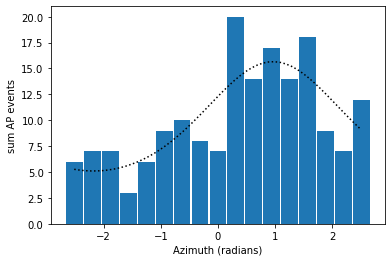

Power_divergenceResult(statistic=13.21580807589058, pvalue=0.6569179175770277)


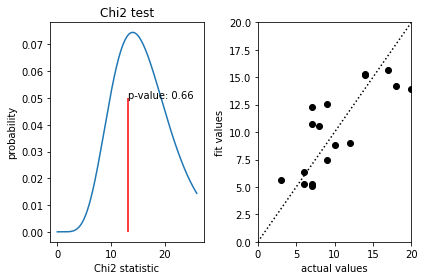

In [8]:
data = np.array([ 6.,  7.,  7.,  3.,  6.,  9., 10.,  8.,  7., 20., 14., 17., 14., 18.,  9.,  7., 12.])
azim = np.array([-144, -126, -108, -90, -72, -54, -36, -18, 0, 18, 36, 54, 72, 90, 108, 126, 144])
azimrad = azim * (np.pi/180)
interp = np.arange(azimrad[0],azimrad[-1],.1)

#data
p = fitVonMises(data, azimrad)
fit = vonMises(*p)

#print the fit parameters
param_labels = ['height', 'mean', 'std']
for i, label in enumerate(param_labels):
    print(label, ':', np.round(p[i], 4))

#graph the data
plt.bar(azimrad, data, width=(np.abs(np.min(azimrad))+np.abs(np.max(azimrad)))/len(data))
plt.xlabel('Azimuth (radians)')
plt.ylabel('sum AP events')

plt.plot(interp, fit(interp), linestyle=':', c='black')
plt.show()


res = chiSquaredTest(data, fit(azimrad))


## Kent distribution

In [9]:
def rodrot(targetvector, rotationaxis, angle):
    # this function does rotation of a vector in 3d space accordingly to
    # Rodrigues rotation formula.
    
    r1 = targetvector*np.cos(angle)
    r2 = np.cross(rotationaxis, targetvector) * np.sin(angle)
    r3 = rotationaxis * (np.transpose(rotationaxis) * targetvector) * (1 - np.cos(angle))
     
    return np.squeeze(r1 + r2 + r3)

def sphericalUnit(theta, phi):
    # this function gives a unit vectors of spherical coordinates.
    # the notation is based on Arfken
    # theta is polar angle
    # phi is azimuthal angle.

    st = np.sin(theta);
    ct = np.cos(theta);
    sp = np.sin(phi);
    cp = np.cos(phi);

    unitvecs = np.array([[st * cp,  ct * cp, -sp],
                [st * sp,  ct * sp,  cp],
                [ct,      -st,      0]])
    
    return unitvecs

def sph2cart(theta, phi):
    # this returns cartesian coord based on the spherical coordinates.
    # this assumes a unit circle
    return [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]

def kent(xyz, height, beta, kappa, gamma1, gamma2, gamma3, base):
    kent_dist = height * np.exp(-kappa) * np.exp(kappa * np.dot(xyz, gamma1) + 
            beta * kappa * (np.dot(xyz, gamma2)**2 - np.dot(xyz, gamma3)**2)) - base 
    return np.squeeze(kent_dist)

def kentdist(kappa, beta, theta, phi, alpha, height, base, xyz):
    xyz = xs[:,:3]

    alpha = 45

    theta_degree = 45 
    theta = theta_degree*np.pi/180

    phi_degree = 45
    phi = (90+phi_degree)*np.pi/180

    n_samples = xyz.shape[0]

    units = sphericalUnit(theta, phi)
    gamma1 = units[:, 0]

    gamma2 = rodrot(units[:, 1], units[:, 0], alpha)
    gamma3 = rodrot(units[:, 2], units[:, 0], alpha)

    gamma1 = np.transpose(gamma1[None,None,:], [1, 2, 0])
    gamma2 = np.transpose(gamma2[None,None,:], [1, 2, 0])
    gamma3 = np.transpose(gamma3[None,None,:], [1, 2, 0])

    return kent(xyz, height, beta, kappa, gamma1, gamma2, gamma3, base)

def kentRandStart():
    kappa = np.random.uniform(low=0, high=100, size=1)
    beta = np.random.uniform(low=-0.5, high=0.5, size=1)
    theta = np.random.uniform(low=0, high=np.pi/2, size=1)
    phi =  np.random.uniform(low = -144 / 180 * np.pi, high = 144 / 180 * np.pi, size=1)
    alpha = np.random.uniform(low = -2*np.pi, high = 2*np.pi, size=1)
    height = np.random.uniform(low=0, high=100, size=1)
    base = np.random.uniform(low=0, high=100, size=1)
    
    return kappa, beta, theta, phi, alpha, height, base

def fitKent(data, xyz):
    '''
    X in radians
    Returns (height, xmean, conc)
    '''
    params = kentRandStart()
    error_function = lambda p: np.ravel(kentdist(*p, xyz) - data)
    p, success = optimize.leastsq(error_function, params)
    
    return p    


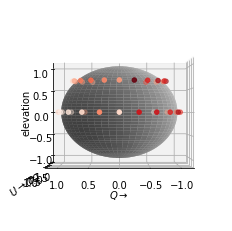

kappa 1.1120170066623463
beta -0.004916467869406517
theta 0.7334823001713396
phi -2.399319788369424
alpha -2.6116138544129415
height 17.086968613517215
base 0.24322056998001498


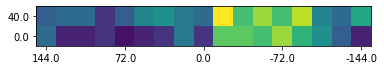

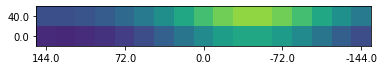

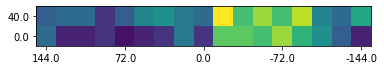

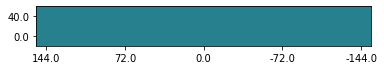

height : 8.7353
Power_divergenceResult(statistic=42.57823939295884, pvalue=0.12273803355612878)


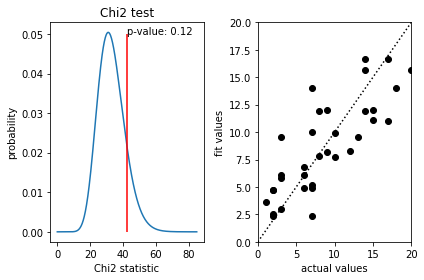

Power_divergenceResult(statistic=109.28282828282829, pvalue=4.233976941704028e-10)


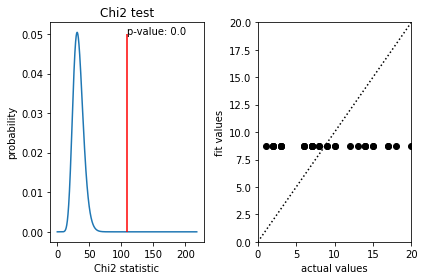

In [11]:
data = np.array([[ 7.,  2.,  2.,  3.,  1.,  2.,  3.,  8.,  3., 15., 15., 14., 17., 13., 10.,  6.,  2.],
                 [ 6.,  7.,  7.,  3.,  6.,  9., 10.,  8.,  7., 20., 14., 17., 14., 18.,  9.,  7., 12.]])


from mpl_toolkits.mplot3d import Axes3D

def grid3d(gridsize = 200):

    u = np.linspace(0, 2 * np.pi, gridsize)
    v = np.linspace(0, np.pi, gridsize)

    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
#     keys = list()
#     points = list()
#     for i in range(gridsize):
#         for j in range(gridsize):
#             points.append([x[i, j], y[i, j], z[i, j]])
#             keys.append((i, j))
#     points = np.array(points)

#     value_for_color = np.ones(gridsize)
#     colors = np.empty((gridsize, gridsize), dtype=tuple)
#     for i, j in keys:
#         colors[i, j] = (1.0, 1.0, 1.0, 1.0)
        
    return x, y, z#, points, colors

azim = -1*np.array([-144, -126, -108, -90, -72, -54, -36, -18, 0, 18, 36, 54, 72, 90, 108, 126, 144])
elev = 90-np.array([0,40])
azim = azim*np.pi/180
elev = elev*np.pi/180

def azimElevCoord(azim, elev, data):
    corz = np.cos(elev)
    xs = np.zeros([elev.shape[0]*azim.shape[0],4])
    n=0
    
    for k in np.arange(corz.shape[0]):
        corx = np.sin(elev[k])*np.sin(azim)
        cory = np.sin(elev[k])*np.cos(azim)
        for i in np.arange(corx.shape[0]):
            xs[n,0] = corx[i]
            xs[n,1] = cory[i]
            xs[n,2] = corz[k]
            xs[n,3] = data[k,i]
            n+=1
    return xs


x, y, z = grid3d(gridsize = 200)

xs = azimElevCoord(azim, elev, data)

f = plt.figure()

ax = f.add_subplot(111, projection='3d')
xx, yy, zz, colors = list(zip(*xs))  # plot only a portion of these values
ax.scatter(1.05 * np.array(xx), 1.05 *
           np.array(yy), 1.05 * np.array(zz), c=colors, cmap='Reds', vmin=0, vmax=20)
ax.plot_surface(x, y, z, rstride=4, cstride=4,
                color='lightgray',
#             facecolors=colors, 
            linewidth=0)
ax.set_xlabel(r"$Q\rightarrow$")
ax.set_ylabel(r"$U\rightarrow$")
ax.set_zlabel('elevation')
# ax.set_zlim(0,1)
ax.view_init(0,90)
# plt.savefig(savedir + 'binned_fr_data_sphere.svg', dpi=300)
plt.show()


interp = np.arange(azimrad[0],azimrad[-1],.1)

xyz = xs[:,:3]

#data
p = fitKent(data.reshape(data.size), xyz)
param_labels = ['kappa', 'beta', 'theta', 'phi', 'alpha', 'height', 'base']
for pa, param in enumerate(param_labels):
    print(param, p[pa])

#graph the data

fitdist = kentdist(*p, xyz).reshape(data.shape)

maxval = np.max(data)
minval=0
plt.imshow(data, vmin=minval, vmax=maxval)
plt.xticks(np.arange(azim.shape[0])[::4], np.round(azim * 180/np.pi)[::4])
plt.yticks(np.arange(elev.shape[0]), np.round(90-elev * 180/np.pi))
plt.ylim(-0.5,1.5)
plt.show()

plt.imshow(fitdist, vmin=minval, vmax=maxval)
plt.xticks(np.arange(azim.shape[0])[::4], np.round(azim * 180/np.pi)[::4])
plt.yticks(np.arange(elev.shape[0]), np.round(90-elev * 180/np.pi))
plt.ylim(-0.5,1.5)
plt.show()



#data
p = fitUniform(data.reshape(data.size), np.arange(data.size))
ufit = uniform(*p, np.arange(data.size))

plt.imshow(data, vmin=minval, vmax=maxval)
plt.xticks(np.arange(azim.shape[0])[::4], np.round(azim * 180/np.pi)[::4])
plt.yticks(np.arange(elev.shape[0]), np.round(90-elev * 180/np.pi))
plt.ylim(-0.5,1.5)
plt.show()

plt.imshow(ufit.reshape(data.shape), vmin=minval, vmax=maxval)
plt.xticks(np.arange(azim.shape[0])[::4], np.round(azim * 180/np.pi)[::4])
plt.yticks(np.arange(elev.shape[0]), np.round(90-elev * 180/np.pi))
plt.ylim(-0.5,1.5)
plt.show()

#print the fit parameters
param_labels = ['height']
for i, label in enumerate(param_labels):
    print(label, ':', np.round(p[i], 4))

kentres = chiSquaredTest(data.reshape(data.size), fitdist.reshape(fitdist.size))

unires = chiSquaredTest(data.reshape(data.size), ufit)
